<a href="https://colab.research.google.com/github/SangminAhn21/DL_Study/blob/main/Python_DeepLearning_PyTorch/PART_03/FashionMNIST_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0+cu111  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
train_dataset = datasets.FashionMNIST(root = '../data/FashionMNIST',
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = '../data/FashionMNIST',
                                      train = False,
                                      transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


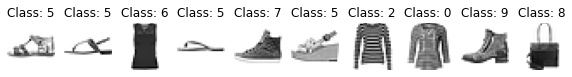

In [7]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title('Class: ' + str(y_train[i].item()))

In [16]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
    
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),)
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [18]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [13]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [11]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)

            test_loss += criterion(decoded, image).item()
            real_image.append(image.to('cpu'))
            gen_image.append(decoded.to('cpu'))

    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.228931
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.033221
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.037951
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.028907
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.024783
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.022081
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.024207
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.023164
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.025607
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.025793

[EPOCH: 1], 	Test Loss: 0.0007


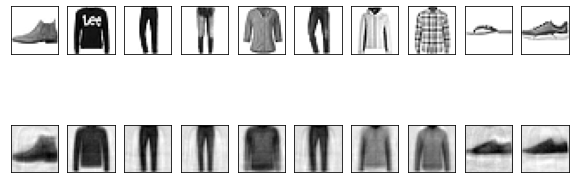

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.024264
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.028219
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.023945
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.028895
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.020941
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.024332
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.022634
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.025347
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.019656
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.023439

[EPOCH: 2], 	Test Loss: 0.0008


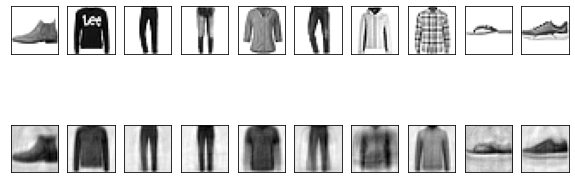

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.027391
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.025331
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.022739
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.021030
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.024109
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.020929
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.020700
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.022524
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.018844
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.020229

[EPOCH: 3], 	Test Loss: 0.0007


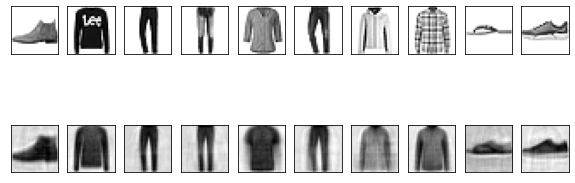

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.017245
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.022753
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.024106
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.022434
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.023938
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.020436
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.018848
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.023753
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.021083
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.022109

[EPOCH: 4], 	Test Loss: 0.0007


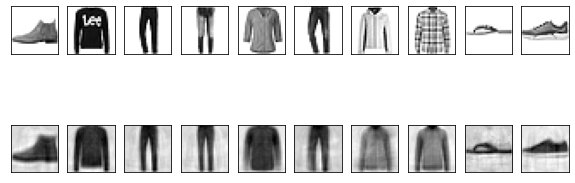

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.020928
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.020221
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.021429
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.024945
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.022798
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.023504
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.020761
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.019481
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.018149
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.019824

[EPOCH: 5], 	Test Loss: 0.0007


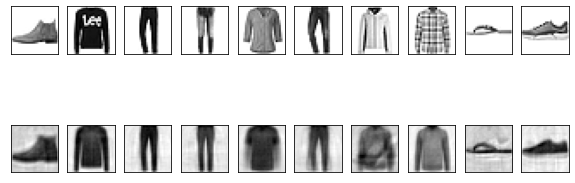

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.026072
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.026954
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.019375
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.021728
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.022434
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.019084
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.025568
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.019757
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.022148
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.019448

[EPOCH: 6], 	Test Loss: 0.0007


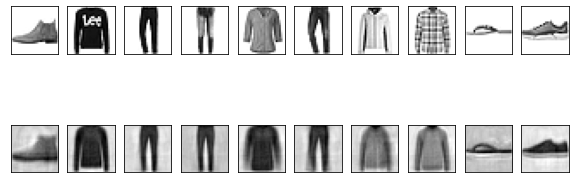

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.024124
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.021099
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.019037
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.021855
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.019178
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.021035
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.021859
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.020785
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.023664
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.018837

[EPOCH: 7], 	Test Loss: 0.0007


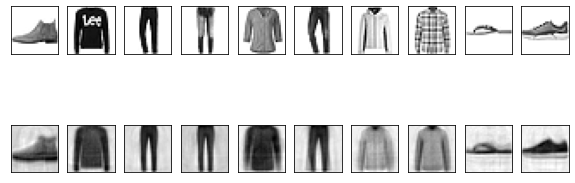

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.018472
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.020479
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.022917
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.022738
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.020491
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.020651
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.024463
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.023294
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.022045
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.022239

[EPOCH: 8], 	Test Loss: 0.0007


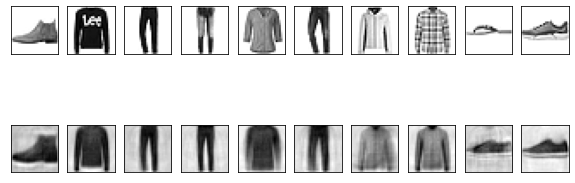

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.022290
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.021247
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.020474
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.025123
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.019921
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.019441
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.025474
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.019039
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.023163
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.021227

[EPOCH: 9], 	Test Loss: 0.0007


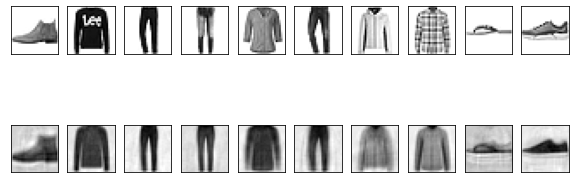

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.022627
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.023587
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.018128
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.021122
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.022821
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.021398
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.020976
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.022484
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.019334
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.020784

[EPOCH: 10], 	Test Loss: 0.0007


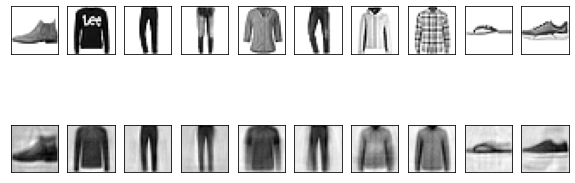

In [19]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}'.format(Epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = 'gray_r')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = 'gray_r')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()